v4

調査とまとめのエージェントを分ける


ライブラリのインポート

In [76]:
# ライブラリのインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import create_react_agent
from typing import List, Dict
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate
)
from langchain.schema import SystemMessage, HumanMessage
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

load_dotenv()


#LangchainのAPIを渡す
os.environ["LANGCHAIN_TRACING"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

#GPTのAPIを渡す
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

#TavilyのAPIを渡す
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")


出力の型を定義

In [77]:
class URLInfo(BaseModel):
    title: str = Field(description="サイトのタイトル")
    url: str = Field(description="サイトのURL")

class OutputSummrize(BaseModel):
    summrize_result: str = Field(description="調査の内容")
    # URL_listをURLInfoモデルに変更
    URL_list: List[URLInfo] = Field(description="記事作成に利用されたサイトのタイトルとURL")


class OutputArticle(BaseModel):
    title: str = Field(description="記事のタイトル")
    main_text: str = Field(description="記事の中身")

LLMの定義

In [78]:
#ツールを利用するエージェント
#ChatOpenAIでチャットモデルを渡す（モデルは変更できる）
model = ChatOpenAI(model="gpt-4o-mini")

# Tavilyの定義　max_results:何件文の検索結果を保持するか
search = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True
)
tools = [search]

search_agent = create_react_agent(model, tools)

In [79]:
#記事をまとめるエージェント
summrize_system_template = '''
あなたは調査内容をまとめるアシスタントです。

{search_result}で得た情報をまとめてください。
また、調査で取得したサイトのタイトルとURL１つ１つを辞書形式({{"title": "...", "url": "..."}})にし、リスト形式で出力してください。
'''

search_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", summrize_system_template)
    ]
)
search_output = model.with_structured_output(
    OutputSummrize
)

summrize_agent = search_prompt | search_output

In [80]:
#記事作成を行うエージェント
system_template = '''
以下の検索結果search_result（{summrize_result}）を活用して、指定されたコンテンツcontent（{content}）に関する記事を日本語で作成してください。

記事のタイトル、導入、本文、まとめの構成を意識してわかりやすい構成を心がけてください。
検索結果から得られる情報を整理・要約し、読者にとって有益で読みやすい記事になるようにしてください。
オリジナリティを保ちつつ、正確かつ最新の情報を盛り込むようにしてください。
Steps
検索結果の内容を把握

search_resultから得られる情報をまず整理し、主要なトピックやキーワードを洗い出してください。
記事のアウトライン作成

タイトル
導入（リード文）
見出し（必要に応じて複数）
まとめ（結論やまとめ）
本文執筆

見出しや小見出しごとに論点をまとめ、論理的な文章構成を心がけてください。
検索結果の情報を根拠に、読者にとって有益なポイントを具体的に示してください。
結論・まとめ

記事全体を振り返り、要点を簡潔に整理して読者の理解を深める結論を提示してください。
次の行動や関連トピックへの誘導など、読者が得られるメリットを示してください。
最終チェック

誤字脱字や情報の正確性、読みやすさなどを確認し、必要に応じて修正してください。
Output Format
テキスト形式で、タイトルからまとめまでの構成を順序立てて書いてください。
見やすさを考慮し、箇条書きや段落を適切に使ってください。
Examples
例1
タイトル: 「[検索結果の主要トピック]を徹底解説」
導入: この記事では…（簡単な背景情報と読者が得られるメリット）
本文

見出し1: 「[見出しのテーマ]」
[検索結果からの情報を例示しながら解説]
見出し2: 「[別の角度や詳細トピック]」
[具体的な事例や追加情報など]
まとめ: [全体の要点、読者への次のステップ]
(実際の記事では、上記より詳しい説明や具体例を記載してください)

Notes
検索結果だけでなく、既存の一般的な知識や文脈も適切に補完して記事を仕上げてください。
search_resultやcontentが十分でない場合は、想定しうる前提条件などを適宜推測して文章を補ってください。

'''

extract_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", system_template),
    ]
)
extract_trends = model.with_structured_output(
    OutputArticle
)
trend_extractor = extract_prompt | extract_trends


グラフの作成

In [81]:
class State(TypedDict):
    content: str #ユーザーが入力した記事の内容
    search_result: str #LLMが調査を行った結果を格納
    summrize_result: str #LLMの調査をまとめた結果を格納
    title: str #生成された記事のタイトル
    main_text:str #生成された記事の内容
    URL_list:List[Dict[str, str]] #URLのリスト

In [82]:
def search(state: State):
    response = search_agent.invoke({"messages": [{"role": "user", "content": f"{state['content']}について調査をしてください"}]})
    state["search_result"] = response["messages"][-1].content
    return state

def search_summrize(state: State):
    response = summrize_agent.invoke(state)
    state["summrize_result"] = response.summrize_result
    state["URL_list"] = response.URL_list
    return state

def generate_article(state: State):
    response = trend_extractor.invoke(state)
    state["title"] = response.title
    state["main_text"] = response.main_text
    return state

In [83]:
workflow = StateGraph(State)

workflow.add_node("search", search)
workflow.add_node("search_summrize", search_summrize)
workflow.add_node("generate_article", generate_article)

workflow.add_edge(START, "search")
workflow.add_edge("search", "search_summrize")
workflow.add_edge("search_summrize", "generate_article")
workflow.add_edge("generate_article", END)

app = workflow.compile()


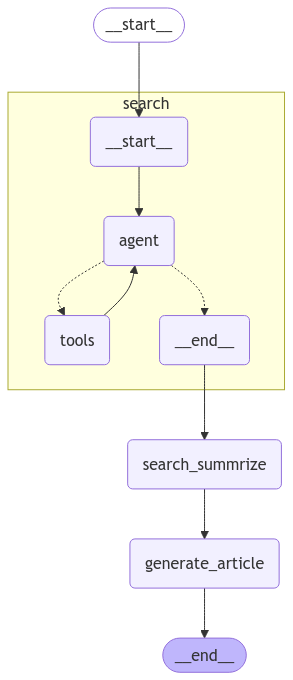

In [84]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))
from IPython.display import Image, display


In [87]:
initial_state = State()
initial_state["content"] = "大谷翔平"


In [88]:
for event in app.stream(initial_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'content': '大谷翔平', 'search_result': '大谷翔平選手に関する最新の情報を以下にまとめます。\n\n### 大谷翔平選手のプロフィール\n- **チーム**：ロサンゼルス・ドジャース\n- **ポジション**：投手・指名打者\n- **出身地**：日本（岩手県）\n- **生年月日**：1994年7月5日\n- **経歴**：\n  - 日本ハムファイターズを経て、2018年よりアメリカのメジャーリーグでプレー。\n  - 2014年には2桁勝利と2桁本塁打を達成。\n  - 2021年にはオールスター史上初の投手と野手両方で選出され、MVPを受賞。\n\n### 近年の成績と功績\n- **2024年シーズン**：\n  - 大谷選手は、初めてのワールドシリーズ制覇を成し遂げた。\n  - 大谷選手は右肘の手術後、指名打者に専念することになったが、59盗塁を記録。\n  - ホームラン50本、盗塁50での「50-50」を達成し、MVPを受賞（これにより、指名打者専念の選手としては初の記録）。\n\n### インタビューおよび最近の動向\n- 大谷選手は、高度なリハビリを行いながら、2024年のシーズンを迎えた。\n- 試練を乗り越え、数々の偉業を達成した背景には大きな努力があった。\n- 翔平選手は、自身のリハビリやシーズンの進行について、「長く感じたが、試合をしているとあっという間に次のシーズンが来る感覚」と語っている。\n\n### マスコミの注目と未来\n- 大谷選手への注目は日本だけでなく、全世界に広がっており、多くの報道が彼のプレーやインタビューを取り上げている。\n- 移籍先のドジャースでも、その存在感を放ち、ファンやメディアの期待が高まっている。\n\nこれらの情報は、日本のメディアを中心に報じられており、彼の今後の活躍にも注目が集まっています。'}
{'content': '大谷翔平', 'search_result': '大谷翔平選手に関する最新の情報を以下にまとめます。\n\n### 大谷翔平選手のプロフィール\n- **チーム**：ロサンゼルス・ドジャース\n- **ポジション**：投手・指名打者\n- **出身地**：日本（岩手県）\n- **生年月日**：1994年7月5日\n- **経歴**：\n  -